In [1]:
# imported necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
#from sklearn.model_selection import cross_val_score
#from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn import model_selection
#from sklearn import cross_validation
from scipy.stats import uniform
import graphviz

In [2]:
import sqlite3
con = sqlite3.connect("final.sqlite")

In [3]:
cleaned_data = pd.read_sql_query("select * from Reviews", con)

In [4]:
cleaned_data.shape

(364171, 12)

In [5]:
cleaned_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


In [6]:
# Sort data based on time
cleaned_data["Time"] = pd.to_datetime(cleaned_data["Time"], unit = "s")
cleaned_data = cleaned_data.sort_values(by = "Time")

In [7]:
cleaned_data["Score"].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [8]:
# Selecting top 100k data-points
final_100k = cleaned_data.iloc[:100000,:]

In [9]:
# converting scores in 0 and 1
final_100k["Score"] = final_100k["Score"].apply(lambda x: 1 if x == "positive" else 0)

C:\Users\premvardhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# Bag of Word

In [10]:
# Function that will compute optimal depth for classifier using cross-validation
def tree_max_depth(X_train, y_train):
    
    depth_of_tree = list(range(5, 40, 3))
    
    # empty list that will hold cv scores
    cv_scores = []

    # perform 3-fold cross validation
    for depth in depth_of_tree:
        tree = DecisionTreeClassifier(max_depth = depth, class_weight = "balanced")
        cv = TimeSeriesSplit(n_splits = 3)
        scores = cross_val_score(tree, X_train, y_train, cv = cv, scoring = "roc_auc")
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best depth
    max_depth = depth_of_tree[MSE.index(min(MSE))]
    print('\nThe optimal depth is %d.' % max_depth)

    # plot validation error vs depth
    plt.plot(depth_of_tree, np.round(MSE, 3))
    plt.title("Validataion Error vs Depth")
    plt.xlabel('Depth')
    plt.ylabel('Validation Error')
    plt.show()

    print("The cross validation error for each depth value is : ", np.round(MSE,3))
    return max_depth

In [11]:
# 100k data which will use to train model after vectorization
X = final_100k["CleanedText"]
print("shape of X:", X.shape)

shape of X: (100000,)


In [12]:
# class label
y = final_100k["Score"]
print("shape of y:", y.shape)

shape of y: (100000,)


In [13]:
# split data into train and test where 70% data used to train model and 30% for test
from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle = False)
print(X_train.shape, y_train.shape, x_test.shape)

(70000,) (70000,) (30000,)


In [14]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.20.0.


In [15]:
# Train Vectorizor
from sklearn.feature_extraction.text import CountVectorizer 

bow = CountVectorizer()
X_train = bow.fit_transform(X_train)
X_train

<70000x31373 sparse matrix of type '<class 'numpy.int64'>'
	with 2094656 stored elements in Compressed Sparse Row format>

In [16]:
# Test Vectorizor
x_test = bow.transform(x_test)
x_test

<30000x31373 sparse matrix of type '<class 'numpy.int64'>'
	with 913202 stored elements in Compressed Sparse Row format>


The optimal depth is 11.


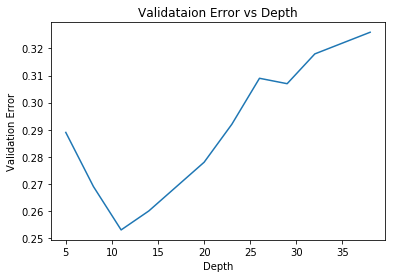

The cross validation error for each depth value is :  [0.289 0.269 0.253 0.26  0.269 0.278 0.292 0.309 0.307 0.318 0.322 0.326]


11

In [17]:
max_depth_bow = tree_max_depth(X_train, y_train)
max_depth_bow

In [18]:
# instantiate learning model max_depth = max_depth_bow
clf = DecisionTreeClassifier(max_depth = max_depth_bow, class_weight = "balanced")
# fitting the model
clf.fit(X_train, y_train)   
# predict the response
pred = clf.predict(x_test)

In [19]:
train_acc_bow = clf.score(X_train, y_train)
print("Train accuracy:", train_acc_bow)

Train accuracy: 0.6998714285714286


In [20]:
test_acc_bow = roc_auc_score(y_test, pred) * 100
print('\nThe test accuracy of decision tree with depth = %f is %.2f%%' % (max_depth_bow, test_acc_bow))


The test accuracy of decision tree with depth = 11.000000 is 72.68%


In [21]:
from sklearn.metrics import f1_score
f1_score(y_test, pred)

0.7873905270542444

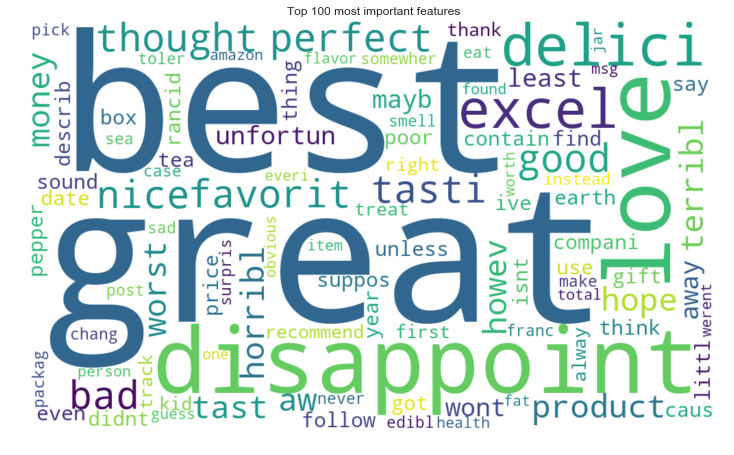

In [33]:
from wordcloud import WordCloud, STOPWORDS

features = bow.get_feature_names()
coef = clf.feature_importances_
coef_df = pd.DataFrame({'word': features, 'coeficient': coef}, index = None)
df = coef_df.sort_values("coeficient", ascending = False)[:100]
cloud = " ".join(word for word in df.word)
stopwords = set(STOPWORDS) 
wordcloud = WordCloud(width = 1000, height = 600, background_color ='white', stopwords = stopwords).generate(cloud) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 8)) 
plt.imshow(wordcloud, interpolation = 'bilinear') 
plt.axis("off") 
plt.title("Top 100 most important features")
plt.tight_layout(pad = 0) 
  
plt.show() 

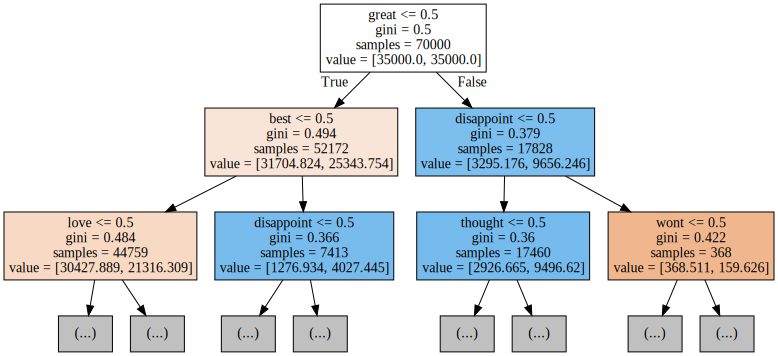

In [23]:
# Visualize decision tree
export_graphviz(clf, out_file="mytree.dot", feature_names = bow.get_feature_names(), max_depth = 2, filled = True)
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [24]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[ 3208,   895],
       [ 8500, 17397]], dtype=int64)

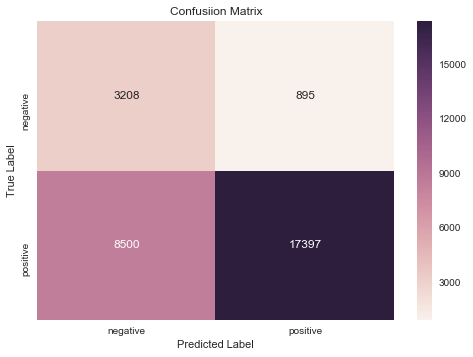

In [25]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [26]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.27      0.78      0.41      4103
           1       0.95      0.67      0.79     25897

   micro avg       0.69      0.69      0.69     30000
   macro avg       0.61      0.73      0.60     30000
weighted avg       0.86      0.69      0.74     30000



**Terminology**<br>

**true positives (TP):** We predicted +ve review, and review is also +ve.<br>
**true negatives (TN):** We predicted -ve, and review is also -ve.<br>
**false positives (FP):** We predicted +ve, but the review is not actually +ve.(Also known as a "Type I error.")<br>
**false negatives (FN):** We predicted -ve, but the review is actually +ve.(Also known as a "Type II error.")<br>


**Observations**</br>
1. From above figure(misclassification error vs optimal depth) It is showing that classification error for each value of depth, when depth is increaseing the error is also increasing. 
2. As I tested our model on unseen data(test data) the accuracy is 76% when depth = 11.
3. In confusion matrix, It is clear that out of 30k unseen data-points classifier predict 17397 +ve and 3208 -ve class label but in real 25897 were +ve and 4103 were -ve.
4. In a nutshell we can say the generalization error is not low means this model does not works well with unseen data.

# Tf-Idf

In [34]:
# data
X = final_100k["CleanedText"]

In [35]:
# Target/class-label
y = final_100k["Score"]

In [36]:
# Split data
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle = False)
print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(70000,) (30000,) (70000,) (30000,)


In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
X_train = tf_idf_vect.fit_transform(X_train)
X_trn = X_train
X_train

<70000x918966 sparse matrix of type '<class 'numpy.float64'>'
	with 4504849 stored elements in Compressed Sparse Row format>

In [38]:
# Convert test text data to its vectorizor
x_test = tf_idf_vect.transform(x_test)
x_tst = x_test
x_test.shape

(30000, 918966)


The optimal depth is 14.


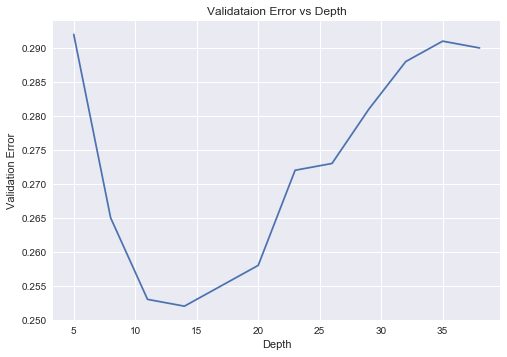

The cross validation error for each depth value is :  [0.292 0.265 0.253 0.252 0.255 0.258 0.272 0.273 0.281 0.288 0.291 0.29 ]


14

In [39]:
# To choose optimal_depth using cross validation
#from sklearn.model_selection import KFold
max_depth_tfidf = tree_max_depth(X_train, y_train)
max_depth_tfidf

In [40]:
# instantiate learning model max_depth = mas_depth_tfidf
clf = DecisionTreeClassifier(max_depth = max_depth_tfidf, class_weight = "balanced")
# fitting the model
clf.fit(X_train, y_train)
# predict the response
pred = clf.predict(x_test)

In [41]:
train_acc_tfidf = clf.score(X_train, y_train)
print("Train accuracy %f%%:" % (train_acc_tfidf))

Train accuracy 0.743071%:


In [42]:
test_acc_tfidf = roc_auc_score(y_test, pred) * 100
print('\nThe accuracy of the decision tree with depth = %f is %.2f%%' % (max_depth_tfidf, test_acc_tfidf))


The accuracy of the decision tree with depth = 14.000000 is 73.82%


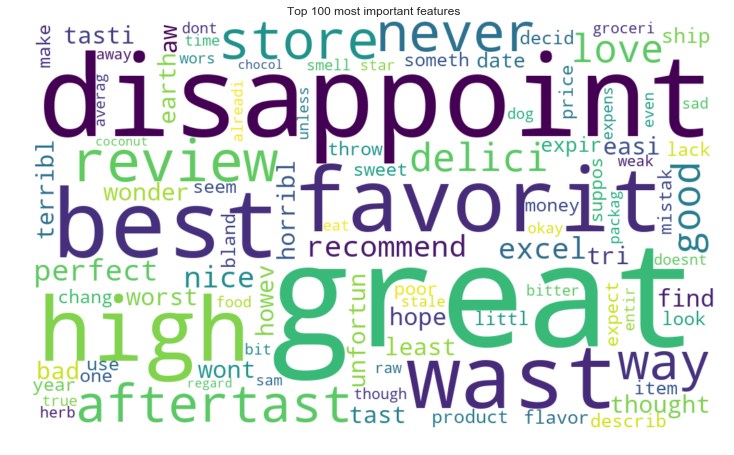

In [43]:
from wordcloud import WordCloud, STOPWORDS

features = tf_idf_vect.get_feature_names()
coef = clf.feature_importances_
coef_df = pd.DataFrame({'word': features, 'coeficient': coef}, index = None)
df = coef_df.sort_values("coeficient", ascending = False)[:100]
cloud = " ".join(word for word in df.word)
stopwords = set(STOPWORDS) 
wordcloud = WordCloud(width = 1000, height = 600, background_color ='white', stopwords = stopwords).generate(cloud) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 8)) 
plt.imshow(wordcloud, interpolation = 'bilinear') 
plt.axis("off") 
plt.title("Top 100 most important features")
plt.tight_layout(pad = 0) 
  
plt.show() 

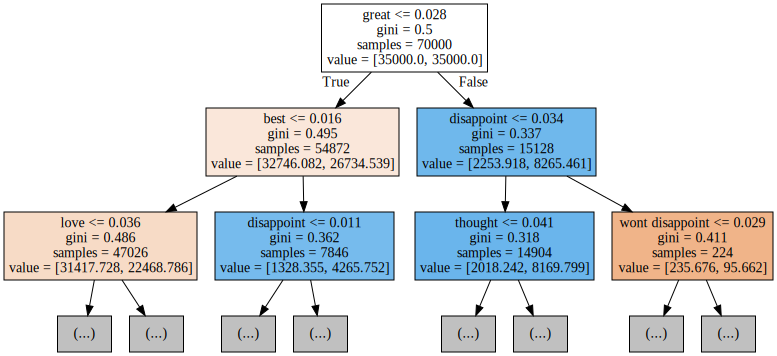

In [44]:
export_graphviz(clf, out_file = "mytree_tfidf.dot", feature_names = tf_idf_vect.get_feature_names(), max_depth = 2, filled = True)
with open("mytree_tfidf.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [45]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[ 3065,  1038],
       [ 7007, 18890]], dtype=int64)

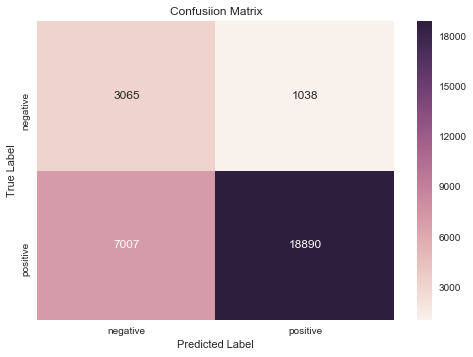

In [46]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [47]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.30      0.75      0.43      4103
           1       0.95      0.73      0.82     25897

   micro avg       0.73      0.73      0.73     30000
   macro avg       0.63      0.74      0.63     30000
weighted avg       0.86      0.73      0.77     30000



**Observations**

1. Decision tree with tfidf when depth = 14 the test error is low than bow.
2. Plotted top 100 most important features in word cloud and also plotted to see how it takes decision to classify +ve review  and -ve review.
3. In a nutshell we can say this model does works well out of other model with unseen data.


# Word2vec

In [125]:
# data
X = final_100k["Text"]
y = final_100k["Score"]

In [126]:
# Split data
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle = False)
print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(70000,) (30000,) (70000,) (30000,)


In [127]:
import re
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [128]:
# Train your own Word2Vec model using your own train text corpus
import gensim
list_of_sent=[]
#for sent in final_40k['Text'].values:
for sent in X_train:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [129]:
w2v_model_train = gensim.models.Word2Vec(list_of_sent, min_count = 5, size = 50, workers = 4)

In [130]:
w2v_model_train.wv.most_similar('like')

[('prefer', 0.649965763092041),
 ('mean', 0.6250419616699219),
 ('think', 0.613554835319519),
 ('miss', 0.5905328989028931),
 ('awful', 0.5858601927757263),
 ('dislike', 0.570219099521637),
 ('enjoy', 0.5696127414703369),
 ('love', 0.5665614604949951),
 ('crave', 0.554947018623352),
 ('know', 0.545619547367096)]

In [131]:
w2v_train = w2v_model_train[w2v_model_train.wv.vocab]

C:\Users\premvardhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [132]:
w2v_train.shape

(16156, 50)

In [133]:
# Train your own Word2Vec model using your own test text corpus
import gensim
list_of_sent_test = []
#for sent in final_40k['Text'].values:
for sent in x_test:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)

In [134]:
w2v_model_test = gensim.models.Word2Vec(list_of_sent_test, min_count = 5, size = 50, workers = 4)

In [135]:
w2v_model_test.wv.most_similar('like')

[('prefer', 0.6247493028640747),
 ('think', 0.5965938568115234),
 ('know', 0.5785714387893677),
 ('want', 0.5568631291389465),
 ('expect', 0.5546354055404663),
 ('mean', 0.5516684651374817),
 ('notice', 0.5498262643814087),
 ('miss', 0.5465028882026672),
 ('fine', 0.5367777347564697),
 ('overpower', 0.5275958776473999)]

In [136]:
w2v_test = w2v_model_test[w2v_model_test.wv.vocab]

C:\Users\premvardhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [137]:
w2v_test.shape

(10801, 50)

# Average word2vec

In [138]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = [] # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0 # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

70000
50


In [139]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = [] # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model_test.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

30000
50


In [140]:
X_train = sent_vectors
#X_train

In [141]:
x_test = sent_vectors_test
#x_test


The optimal depth is 5.


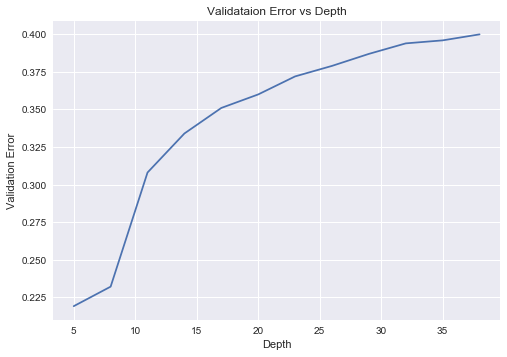

The cross validation error for each depth value is :  [0.219 0.232 0.308 0.334 0.351 0.36  0.372 0.379 0.387 0.394 0.396 0.4  ]


5

In [142]:
# To choose best depth using cross validation
#from sklearn.model_selection import KFold
#from sklearn.model_selection import KFold
max_depth_avgw2v = tree_max_depth(X_train, y_train)
max_depth_avgw2v

In [143]:
# instantiate learning model maz_depth = max_depth_avgw2v
clf = DecisionTreeClassifier(max_depth = max_depth_avgw2v, class_weight = "balanced")
# fitting the model
clf.fit(X_train, y_train)
# predict the response
pred = clf.predict(x_test)

In [144]:
train_acc_avgw2v = clf.score(X_train, y_train)
test_acc_avgw2v = roc_auc_score(y_test, pred) * 100
print("Train accuracy:", train_acc_avgw2v)
print('\nThe accuracy of the decision tree with depth = %f is %.2f%%' % (max_depth_avgw2v, test_acc_avgw2v))

Train accuracy: 0.7163714285714285

The accuracy of the decision tree with depth = 5.000000 is 50.49%


In [145]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[  193,  3910],
       [  964, 24933]], dtype=int64)

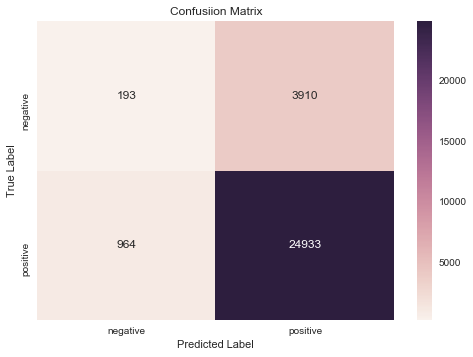

In [146]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [147]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.17      0.05      0.07      4103
           1       0.86      0.96      0.91     25897

   micro avg       0.84      0.84      0.84     30000
   macro avg       0.52      0.50      0.49     30000
weighted avg       0.77      0.84      0.80     30000



**Observations**
1. Tree depth is 5 and It may be underfitting.

# TFIDF Word2Vec

In [73]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model_train.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = X_trn[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

C:\Users\premvardhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


In [80]:
print(len(tfidf_sent_vectors))
import pickle
filename = "tfidf_w2v_train"
fp = open(filename, "wb")
pickle.dump(tfidf_sent_vectors, fp)
print("File Sucessfully saved")
fp.close()

70000
File Sucessfully saved


In [151]:
fp = open("tfidf_w2v_train", "rb")
X_train = pickle.load(fp)
fp.close()

In [82]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model_test.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = x_tst[row, tfidf_feat.index(word)]
            sent_vec += (vec * tfidf)
            weight_sum += tfidf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1  

C:\Users\premvardhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


In [83]:
len(tfidf_sent_vectors_test)
filename = "tfidf_w2v_test"
fp = open(filename, "wb")
pickle.dump(tfidf_sent_vectors_test, fp)
print("File Sucessfully saved")
fp.close()

File Sucessfully saved


In [152]:
fp = open("tfidf_w2v_test", "rb")
x_test = pickle.load(fp)
fp.close()

In [153]:
X_train = np.nan_to_num(X_train)

In [154]:
x_test = np.nan_to_num(x_test)


The optimal depth is 5.


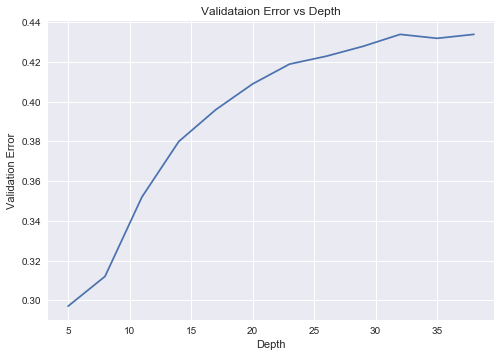

The cross validation error for each depth value is :  [0.297 0.312 0.352 0.38  0.396 0.409 0.419 0.423 0.428 0.434 0.432 0.434]


5

In [155]:
# To choose optimal_depth using cross validation
#from sklearn.model_selection import KFold
max_depth_tfidfw2v = tree_max_depth(X_train, y_train)
max_depth_tfidfw2v

In [156]:
# instantiate learning model 
clf = DecisionTreeClassifier(max_depth = max_depth_tfidfw2v, class_weight = "balanced")
# fitting the model
clf.fit(X_train, y_train)
# predict the response
pred = clf.predict(x_test)

In [157]:
# Accuracy on train data
train_acc_tfidfw2v = clf.score(X_train, y_train)
print("Train accuracy", train_acc_tfidfw2v)

Train accuracy 0.6197142857142857


In [159]:
test_acc_tfidfw2v_grid = roc_auc_score(y_test, pred) * 100
print('\nThe accuracy of the desicion tree with depth = %0.3f is %f%%' % (max_depth_tfidfw2v, test_acc_tfidfw2v_grid))


The accuracy of the desicion tree with depth = 5.000 is 55.918905%


In [160]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[ 3765,   338],
       [20698,  5199]], dtype=int64)

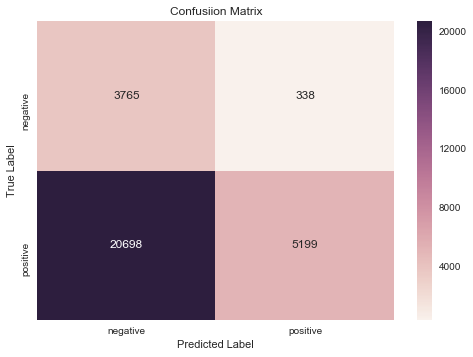

In [161]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [162]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.15      0.92      0.26      4103
           1       0.94      0.20      0.33     25897

   micro avg       0.30      0.30      0.30     30000
   macro avg       0.55      0.56      0.30     30000
weighted avg       0.83      0.30      0.32     30000



 **Observations**
1. The tree depth is very low and hence it could so happen that model is underfitting.
2. Confusion matrix clearing showing that our model prediction is low while predicting -ve class but in majority class prediction its making much more error.

**Conclusions** 
1. Decision tree often does not work well with high dimension data but for bow and tfidf works slightly good than w2v.
3. overall, None of the models are performing well on unseen data, when our performence measure is "roc_auc_score". Here, We are dealing with imbalanced data, hence we should also try f1-score, balanced accuracy etc.

In [163]:
# model performence table
import itable
models = pd.DataFrame({'Model': ['Decision tree with Bow', "Decision tree with TFIDF", "Decision tree with avgw2v", "Decision tree with TFIDFW2V"], 'Hyper Parameter(depth)': [max_depth_bow, max_depth_tfidf, max_depth_avgw2v, max_depth_tfidfw2v ], 'Train Error': [1-train_acc_bow, 1-train_acc_tfidf, 1-train_acc_avgw2v, 1-train_acc_tfidfw2v], 'Test Error': [100-test_acc_bow, 100-test_acc_tfidf, 100-test_acc_avgw2v, 100-test_acc_tfidfw2v_grid], 'Auc Score': [test_acc_bow, test_acc_tfidf, test_acc_avgw2v, test_acc_tfidfw2v_grid]}, columns = ["Model", "Hyper Parameter(depth)", "Train Error", "Test Error", "Auc Score"]).sort_values(by = 'Auc Score', ascending=False)
itable.PrettyTable(models, tstyle=itable.TableStyle(theme = "theme1"), center = True, header_row = True)

,Model,Hyper Parameter(depth),Train Error,Test Error,Auc Score
1,Decision tree with TFIDF,14,0.2569285714285714,26.177875059534628,73.82212494046537
0,Decision tree with Bow,11,0.3001285714285714,27.317820984725373,72.68217901527463
3,Decision tree with TFIDFW2V,5,0.38028571428571434,44.081095141798485,55.918904858201515
2,Decision tree with avgw2v,5,0.28362857142857145,49.50928183963862,50.49071816036138
